<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2024/blob/main/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Step 2: Define the VAE Model

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Step 3: Define the Loss Function

In [3]:
def vae_loss(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Step 4: Prepare the Data

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 29.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 864kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 7.94MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.48MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Step 5: Initialize the Model, Optimizer, and Training Loop

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = vae_loss(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item() / len(data):.4f}')

    print(f'====> Epoch: {epoch+1}, Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Batch 0/469, Loss: 548.7528
Epoch 1/10, Batch 100/469, Loss: 174.7357
Epoch 1/10, Batch 200/469, Loss: 154.6047
Epoch 1/10, Batch 300/469, Loss: 138.0626
Epoch 1/10, Batch 400/469, Loss: 132.2031
====> Epoch: 1, Average loss: 163.8553
Epoch 2/10, Batch 0/469, Loss: 132.5268
Epoch 2/10, Batch 100/469, Loss: 123.8026
Epoch 2/10, Batch 200/469, Loss: 119.6807
Epoch 2/10, Batch 300/469, Loss: 119.3211
Epoch 2/10, Batch 400/469, Loss: 115.6559
====> Epoch: 2, Average loss: 121.8115
Epoch 3/10, Batch 0/469, Loss: 116.5135
Epoch 3/10, Batch 100/469, Loss: 120.4553
Epoch 3/10, Batch 200/469, Loss: 112.5194
Epoch 3/10, Batch 300/469, Loss: 114.3770
Epoch 3/10, Batch 400/469, Loss: 112.6325
====> Epoch: 3, Average loss: 114.8457
Epoch 4/10, Batch 0/469, Loss: 109.9149
Epoch 4/10, Batch 100/469, Loss: 110.1161
Epoch 4/10, Batch 200/469, Loss: 109.0288
Epoch 4/10, Batch 300/469, Loss: 113.5785
Epoch 4/10, Batch 400/469, Loss: 109.7888
====> Epoch: 4, Average loss: 111.9456
Epoch 5/10, 

# Step 6: Visualize the Results

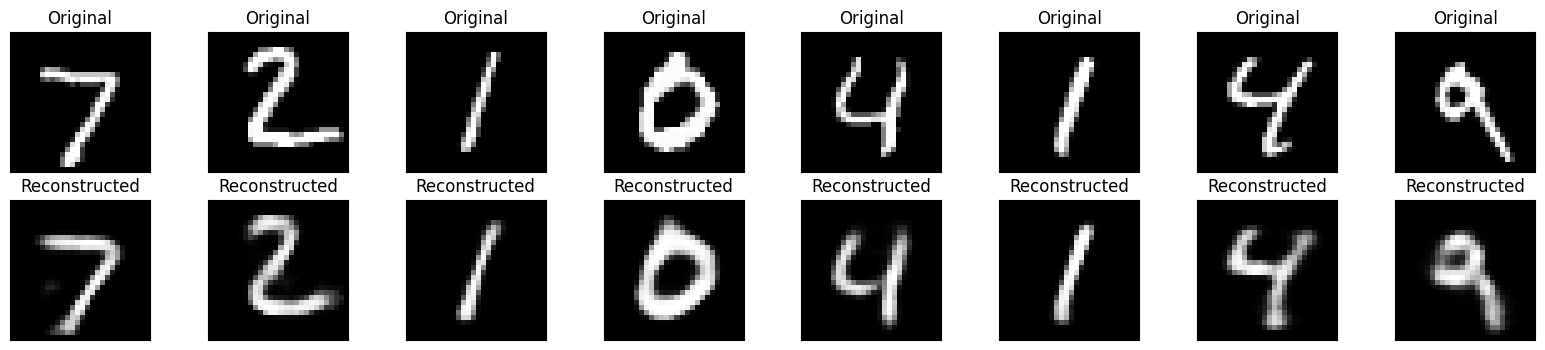

In [6]:
def plot_reconstructions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon_batch, _, _ = model(data)
        recon_batch = recon_batch.cpu()
        data = data.cpu()

        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n], recon_batch.view(data.size(0), 1, 28, 28)[:n]])
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(data[i].squeeze(), cmap='gray')
            plt.title("Original")
            plt.xticks([])
            plt.yticks([])

            # Display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_batch[i].view(28, 28).squeeze(), cmap='gray')
            plt.title("Reconstructed")
            plt.xticks([])
            plt.yticks([])
        plt.show()

plot_reconstructions(vae, test_loader, device)

# Summary

This code defines a VAE model, trains it on the MNIST dataset, and visualizes the original and reconstructed images. The VAE is trained using the Adam optimizer and a combination of binary cross-entropy reconstruction loss and KL divergence regularization. The results are visualized using matplotlib.